# Imports

In [1]:
from  functools import partial
import numpy as np
import pandas as pd
from plot import *
set_things()

import scipy.integrate
from sklearn.metrics import r2_score

# Loading files

In [16]:
US_State_Data = pd.read_excel (r'USA_Data.xlsx')

#loading population of states
State_pop=(US_State_Data.take([3],axis=1).T).to_numpy()
US_State_pop=[]
for i in State_pop:
    US_State_pop.append(i)
    
#loading states name
State_name=(US_State_Data.take([0],axis=1).T).to_numpy()

statewise_pop = {}
for i in range(len(State_pop[0])):
    statewise_pop.update({State_name[0][i]:State_pop[0][i]})

# Model class

In [3]:
class Multi_SEIR():
    def __init__(self,sub_population_num,l1=None):
        self.n_population = sub_population_num
        self.y = None
        if type(l1)==type([]):
            X0,W0,Y0,Z0,D0 = l1
        else:
            X0 = np.ones((sub_population_num,sub_population_num))*1000
            W0 = np.zeros((sub_population_num,sub_population_num))
            Y0 = np.ones((sub_population_num,sub_population_num))*1
            Z0 = np.zeros((sub_population_num,sub_population_num))
            D0 = np.zeros((sub_population_num,sub_population_num))
        y0 = np.hstack([X0.ravel(),W0.ravel(),Y0.ravel(),Z0.ravel(),D0.ravel()])
        self.y0 = y0
        self.diff = {'X_d':[], 'W_d':[], 'Y_d':[], 'Z_d':[], 'D_d':[],}
        self._spacer = '\n'
    
    def sumit(self,t,y,fs,*args,**kwargs):
        s = np.zeros(self.n_population*self.n_population)
        for i in fs:
            s += i(t,y,self.y,**kwargs)
        return s
    
    def solve(self,t):
        def system(y,t):
            ret = np.hstack([self.sumit(t,y,self.diff[k]) for k in self.diff])
            return ret.ravel()
        args = ()
        self.y = scipy.integrate.odeint(system,self.y0,t,args=args)
    
    def __repr_text(self,text):
        return (self._spacer+text)
    
    def __repr__(self):
        t = self.__repr_text
        text = t("Multi-SEIR model with following parameters:")
        text += t("Total number of sub population: {}".format(self.n_population))
        self._spacer = "\n"
        text += t("Initial conditions: ")
        
        self._spacer = "\n\t"
        n = self.n_population*self.n_population
        names = list(self.diff.keys())
        for i in range(5):
            text += t("{}: ".format(names[i])+self.y0[i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())

        self._spacer = "\n\n"
        text += t("Transitions:")
        for k,v in self.diff.items():
            self._spacer = "\n\t\n"
            text += t("{}: ".format(k))
            self._spacer = "\n\t\t"
            text += t("{}".format(v))
        
        if type(self.y)!=type(None):
            for i in range(5):
                text += t("{}: ".format(names[i])+self.y[-1][i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())
            
        return text
    
    def add(self,name,fs):
        if type(fs)!=type([]):
            fs = [fs]
        for f in fs:
            self.diff[name] += [partial(f,dim=self.n_population)]
            

In [7]:
dim = len(State_name[0])
# day 1 = 4th March 2020
State_cases_Data = pd.read_excel (r'state_cases_day.xlsx')
State_cases=(State_cases_Data.take([2],axis=1).T).to_numpy()
Names=(State_cases_Data.take([0],axis=1).T).to_numpy()

# Transition functions

In [8]:
def f(t,y,y_,B=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    N = X+Y+W+Z
    ret =  sign*B*X*(Y.sum(axis=1)/N.sum(axis=1)).reshape(-1,1)
    return ret.ravel()

def g(t,y,y_,sig=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*sig*W
    return ret.ravel()

def h(t,y,y_,gam=0,rho=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*gam*Y*(1-rho)
    return ret.ravel()

def q(t,y,y_,rho=0.01,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*rho*Y
    return ret.ravel()


# Wrapper functions over model for curve fit

In [9]:
def func(t,B,POP=0.32e9,I0=258):
    sig = 1/7
    gam = 1/3
    rho = 0

    x0 = np.array([[POP]])
    y0 = np.array([[I0]])
    w0 = 2*y0
    z0 = 0*y0
    d0 = 0*y0

    model1 = Multi_SEIR(1,[x0,w0,y0,z0,d0])

    model1.add('X_d', [partial(f,B=B,sign=-1),])

    model1.add('W_d', [partial(f,B=B,sign=1),
                        partial(g,sig=sig,sign=-1),])

    model1.add('Y_d', [partial(g,sig=sig,sign=1),
                        partial(h,gam=gam,rho=rho,sign=-1),
                        partial(q,rho=rho,sign=-1),])

    model1.add('Z_d', [partial(h,gam=gam,rho=rho,sign=1),])

    model1.add('D_d', [partial(q,rho=rho,sign=1)])

    model1.solve(t)
    
    ret = model1.y
    
    return ret[:,2]

# Data for US

In [10]:
ydata0 = None
StatesName=[]

cases_data={}
for i in range(0,50):
    pop='{}'.format(Names[0][i*32])
    cases_data.update({pop : State_cases[0][32*i:32*(i+1)]})
    StatesName.append(pop)
    

pop='United States'
cases_data.update({pop : State_cases[0][1643:1675]})

month=['March','April']
def get_data(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+14]
    DATA=Data[p:p+14]
    return ydata0, DATA

def get_data_US(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+14]
    DATA=Data[p:p+14]
    return ydata0, DATA

def get_data_US_plot(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+32]
    DATA=Data[p:p+32]
    return ydata0, DATA

# Curve fitting using scipy.optimize.curve_fit

In [11]:
from scipy.optimize import curve_fit
R0 = None
def get_me_R0(func,ydata0):
    popt, pcov = curve_fit(func,range(len(ydata0)),ydata0,p0=[1])
    R0 = popt*3
    return R0, pcov


# Plots

In [12]:
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.bf'] = 'Arial'
plt.rcParams['axes.formatter.use_mathtext'] = True


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif': ['Arial']})
rc('text', usetex=False)
def set_font(p,plt):
    for size in ['axes.titlesize','axes.labelsize','font.size','figure.titlesize','legend.fontsize','xtick.labelsize','ytick.labelsize']:
        plt.rcParams[size] = p

set_font(26,plt)

In [13]:
def plot_this(name,DATA,ydata0,y,R0,pcov,R2):
    Date = DATA

    label = "Prediction"
    txt = "R$^2$ = {:.2f}\nR$_0$ = {:.2f}".format(R2,*R0.ravel())
    
    plt.gca().text(0.7,0.1,txt,transform=plt.gca().transAxes,)
    
    plt.plot(y,lw=2, label=label )
    
    label = "Observed (I$_0$ = {})".format(ydata0[0])
    plt.plot(ydata0,'D',label=label)

    plt.yscale('log')
    plt.legend(loc=2)
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    
    period = "({} to {}, 2020)".format(Date[0],Date[-1])
    plt.title(name.split('_')[0]+"\n"+"{}".format(period))

C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Alabama
Alaska
Arizona
Arkansas


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


California
Colorado
Connecticut
Delaware


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Florida
Georgia
Hawaii
Idaho


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Illinois
Indiana
Iowa
Kansas


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Kentucky
Louisiana
Maine
Maryland


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Massachusetts
Michigan
Minnesota
Mississippi

C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Missouri


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Montana
Nebraska
Nevada


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


New Hampshire
New Jersey
New Mexico


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


New York
North Carolina
North Dakota
Ohio

C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Oklahoma
Oregon
Pennsylvania
Rhode Island

C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



South Carolina


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


South Dakota
Tennessee


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Texas
Utah


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Vermont


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Virginia
Washington
West Virginia


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Wisconsin
Wyoming


C:\Users\Sp.mmi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


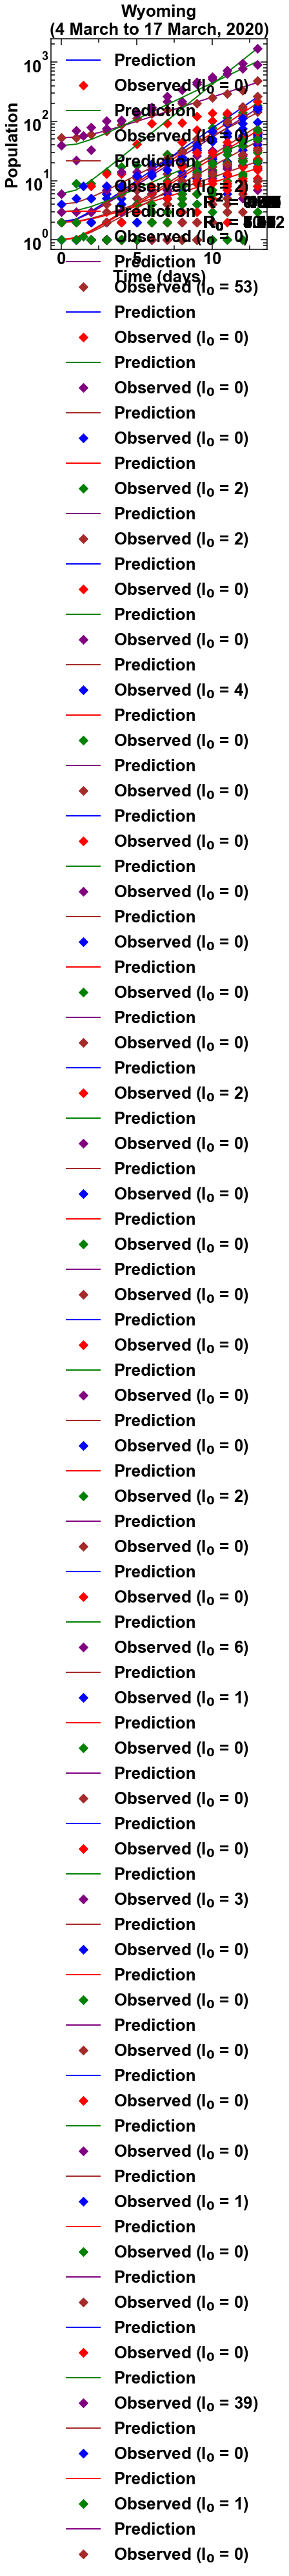

In [17]:
states = StatesName

def optim(state):    
    def g(state,p):
        ydata0, DATA = get_data(state,p)
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        R0, pcov = get_me_R0(f1,ydata0)
        y = f1(range(len(ydata0)),R0/3)
        R2 = r2_score(ydata0.ravel(),y.ravel())
        return R2, R0, pcov

    noskip = False
    R2_0 = -100
    R0_0 = np.array([-1])
    i_0 = 40
    pcov_0 = 0
    
    for i in range(0,1):
        R2, R0, pcov = g(state,i)
        if R2_0<R2:
            R2_0 = 1*R2
            R0_0 = 1*R0
            i_0 = 1*i
            pcov_0 = 1*pcov
            
        if R2>0.9:
            ydata0, DATA = get_data(state,i)
            noskip = True
            break

    if noskip:
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        y = f1(range(len(ydata0)),R0/3)
        R0_values = {state: [R0[0],R2,pcov[0,0]] }
        plot_this(state,DATA,ydata0,y,R0,pcov,R2)
        return R0_values
    else:
        ydata0, DATA = get_data(state,i_0)
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        y = f1(range(len(ydata0)),R0_0/3)
        R0_values = {state: [R0_0[0],R2_0,pcov_0[0,0]]}
        plot_this(state,DATA,ydata0,y,R0_0,pcov_0,R2_0)
        return R0_values
    
def rename(name):
    l = [name[0]]
    for i in name[1:]:
        if i!=i.lower():
            l += [' ']
        l += [i]
    return ''.join(l)
    

R0_values = {}
for state in states:
    fig, ax = panel(1,1,dpi=400,b_p=0.1,t_p=0.1)
    R0_values.update(optim(state))
    filename = "./USA_Images-1/"+state+".png"
    fig.savefig(filename)
    print(state)
    

In [18]:
R0_df = pd.DataFrame(list(R0_values.values()),index=R0_values.keys(),columns=['R0','R2','pcov'])
R0_df=R0_df.sort_values(by=['R2'],ascending=False)

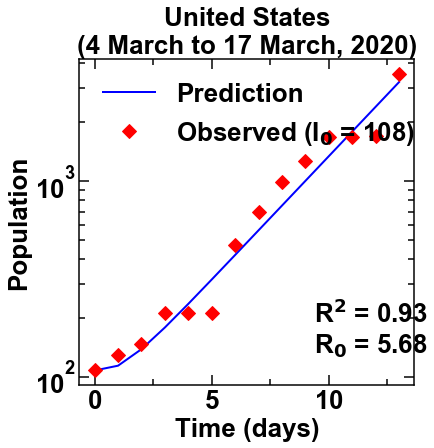

In [19]:
US_ydata0 = State_cases[0][1600:1677]
y1=[]
def optim_US(state):    
    def g(state,p):
        ydata0, DATA = get_data_US(state,p)
        f1 = partial(func,POP=0.32e9,I0=ydata0[0])
        R0, pcov = get_me_R0(f1,ydata0)
        y = f1(range(len(ydata0)),R0/3)
        R2 = r2_score(ydata0.ravel(),y.ravel())
        return R2, R0, pcov

    noskip = False
    R2_0 = 0
    R0_0 = -1
    for i in range(0,1):
        R2, R0, pcov = g(state,i)
        if R2_0<R2:
            R2_0 = R2
            R0_0 = R0
            
        if R2>0.9:
            ydata0, DATA = get_data_US(state,i)
            noskip = True
            break

    if noskip:
        f1 = partial(func,POP=0.32e9,I0=ydata0[0])
        y = f1(range(len(ydata0)),R0/3)
        y1.append(f1(range(200),R0/3))
        R0_values = {state: [R0[0],R2,pcov[0,0]] }
        plot_this(state,DATA,ydata0,y,R0,pcov,R2)
        return R0_values
    else:
        return {state: [R0_0,R2_0,0] }


R0_values.update(optim_US('United States'))

In [20]:
import pickle

R0 = R0_df['R0']
mask = R0_df['R2']>0.85
R0[~mask] = R0[mask].mean()

mask1 = R0_df['R2']==1
R0[mask1] = R0[mask].mean()

temp_dict = {}
for k,v in zip(R0.index,R0.values):
    temp_dict[k] = v

with open('./R0_week1.dict','wb') as file:
    pickle.dump(temp_dict,file)

In [21]:
yyyy_0_75 = np.array([118.        , 123.43247686, 146.50977581, 184.80704587,
       239.73228208, 315.5483321 , 419.39523769,4.19395238e+02, 5.46324044e+02, 6.93491269e+02, 8.72508304e+02,
       1.09512488e+03, 1.37482708e+03, 1.72812156e+03, 2.17581566e+03,
       2.74447864e+03, 3.46823036e+03, 4.39103936e+03, 5.56966419e+03,
       7.07749560e+03, 9.00956552e+03, 1.14890688e+04, 1.46759443e+04,
       1.87779779e+04, 2.40654489e+04, 3.08902647e+04, 3.97110952e+04,
       5.11260670e+04, 6.59158488e+04, 8.50998570e+04, 1.10009461e+05,
       1.42383589e+05, 1.84492573e+05, 2.39297969e+05, 3.10657038e+05,
       4.03581429e+05, 5.24560075e+05, 6.81952799e+05, 8.86452995e+05,
       1.15160578e+06, 1.49433747e+06, 1.93540747e+06, 2.49962339e+06,
       3.21557096e+06, 4.11450124e+06, 5.22795433e+06, 6.58377201e+06,
       8.20044847e+06, 1.00804622e+07, 1.22041406e+07, 1.45262524e+07,
       1.69774663e+07, 1.94711744e+07, 2.19142478e+07, 2.42185461e+07,
       2.63102718e+07, 2.81355340e+07, 2.96619701e+07, 3.08772267e+07,
       3.17849824e+07, 3.23994337e+07, 3.27395047e+07, 3.28239697e+07,
       3.26686076e+07, 3.22856597e+07, 3.16852897e+07, 3.08782307e+07,
       2.98785659e+07, 2.87056807e+07, 2.73848568e+07, 2.59464251e+07,
       2.44238422e+07, 2.28512735e+07, 2.12612498e+07, 1.96827985e+07,
       1.81402507e+07, 1.66527334e+07, 1.52342360e+07, 1.38940831e+07,
       1.26376427e+07, 1.14671210e+07, 1.03823321e+07, 9.38137762e+06,
       8.46119841e+06, 7.61800117e+06, 6.84756771e+06, 6.14547046e+06,
       5.50721771e+06, 4.92834916e+06, 4.40449866e+06, 3.93143618e+06,
       3.50509622e+06, 3.12159791e+06, 2.77725932e+06, 2.46860724e+06,
       2.19238321e+06, 1.94554613e+06, 1.72527193e+06, 1.52895038e+06,
       1.35417958e+06, 1.19875848e+06, 1.06067789e+06, 9.38110165e+05,
       8.29398278e+05, 7.33044304e+05, 6.47697819e+05, 5.72144355e+05,
       5.05294158e+05, 4.46171290e+05, 3.93903369e+05, 3.47711799e+05,
       3.06902740e+05, 2.70858650e+05, 2.39030557e+05, 2.10930944e+05,
       1.86127270e+05, 1.64236095e+05, 1.44917744e+05, 1.27871511e+05,
       1.12831346e+05, 9.95619781e+04, 8.78554432e+04, 7.75279897e+04,
       6.84173149e+04, 6.03801057e+04, 5.32898483e+04, 4.70348804e+04,
       4.15166720e+04, 3.66482908e+04, 3.23530520e+04, 2.85633133e+04,
       2.52194155e+04, 2.22687470e+04, 1.96649088e+04, 1.73669881e+04,
       1.53389048e+04, 1.35488448e+04, 1.19687561e+04, 1.05739014e+04,
       9.34246731e+03, 8.25521852e+03, 7.29519167e+03, 6.44742694e+03,
       5.69873118e+03, 5.03746795e+03, 4.45337371e+03, 3.93739531e+03,
       3.48154658e+03, 3.07878215e+03, 2.72288636e+03, 2.40837459e+03,
       2.13040781e+03, 1.88471541e+03, 1.66752863e+03, 1.47552114e+03,
       1.30575679e+03, 1.15564374e+03, 1.02289384e+03, 9.05486835e+02,
       8.01638875e+02, 7.09774660e+02, 6.28502975e+02, 5.56595076e+02,
       4.92965526e+02, 4.36655474e+02, 3.86817809e+02, 3.42704010e+02,
       3.03652644e+02, 2.69079175e+02, 2.38466949e+02, 2.11359295e+02,
       1.87352517e+02, 1.66089687e+02, 1.47255212e+02, 1.30570036e+02,
       1.15787351e+02, 1.02688867e+02, 9.10815027e+01, 8.07944442e+01,
       7.16765675e+01, 6.35941515e+01, 5.64288655e+01, 5.00759871e+01,
       4.44428248e+01, 3.94473256e+01, 3.50168561e+01, 3.10871048e+01,
       2.76011245e+01, 2.45084884e+01, 2.17645347e+01, 1.93297032e+01,
       1.71689500e+01, 1.52512310e+01, 1.35490394e+01, 1.20380011e+01,
       1.06965162e+01, 9.50544005e+00, 8.44780409e+00, 7.50856580e+00,
       6.67438842e+00])

In [22]:
yyyy_1=np.array([118.        , 123.43155744, 146.50355544, 184.7900142 ,
       239.70295696, 315.51603868, 419.39171458,4.19391715e+02, 5.46354379e+02, 6.93527481e+02, 8.72547763e+02,
       1.09519356e+03, 1.37499018e+03, 1.72850178e+03, 2.17662264e+03,
       2.74605324e+03, 3.47110641e+03, 4.39603541e+03, 5.57801288e+03,
       7.09102861e+03, 9.03097765e+03, 1.15222913e+04, 1.47266761e+04,
       1.88544282e+04, 2.41793885e+04, 3.10585018e+04, 3.99575460e+04,
       5.14846634e+04, 6.64346059e+04, 8.58465554e+04, 1.11079573e+05,
       1.43911311e+05, 1.86666125e+05, 2.42380734e+05, 3.15016589e+05,
       4.09729149e+05, 5.33204539e+05, 6.94070626e+05, 9.03380843e+05,
       1.17515584e+06, 1.52693507e+06, 1.98024148e+06, 2.56078534e+06,
       3.29813412e+06, 4.22446131e+06, 5.37192070e+06, 6.76829605e+06,
       8.43093017e+06, 1.03597281e+07, 1.25310162e+07, 1.48946753e+07,
       1.73766581e+07, 1.98870505e+07, 2.23316348e+07, 2.46234149e+07,
       2.66912825e+07, 2.84846479e+07, 2.99742657e+07, 3.11501334e+07,
       3.20171846e+07, 3.25897342e+07, 3.28859481e+07, 3.29235101e+07,
       3.27173808e+07, 3.22797570e+07, 3.16217828e+07, 3.07561496e+07,
       2.96995643e+07, 2.84742422e+07, 2.71080194e+07, 2.56331363e+07,
       2.40841262e+07, 2.24953918e+07, 2.08989886e+07, 1.93229531e+07,
       1.77903134e+07, 1.63187572e+07, 1.49208266e+07, 1.36044779e+07,
       1.23738408e+07, 1.12300401e+07, 1.01719788e+07, 9.19701986e+06,
       8.30153517e+06, 7.48132140e+06, 6.73189447e+06, 6.04868624e+06,
       5.42716841e+06, 4.86292593e+06, 4.35169842e+06, 3.88940277e+06,
       3.47214496e+06, 3.09622665e+06, 2.75814926e+06, 2.45461610e+06,
       2.18253348e+06, 1.93901046e+06, 1.72135699e+06, 1.52708055e+06,
       1.35388118e+06, 1.19964507e+06, 1.06243687e+06, 9.40490883e+05,
       8.32201612e+05, 7.36113630e+05, 6.50911369e+05, 5.75408711e+05,
       5.08538789e+05, 4.49344066e+05, 3.96966796e+05, 3.50639973e+05,
       3.09678815e+05, 2.73472838e+05, 2.41478462e+05, 2.13212259e+05,
       1.88244716e+05, 1.66194593e+05, 1.46723755e+05, 1.29532528e+05,
       1.14355479e+05, 1.00957660e+05, 8.91311924e+04, 7.86922398e+04,
       6.94782858e+04, 6.13457122e+04, 5.41676423e+04, 4.78320087e+04,
       4.22398576e+04, 3.73038235e+04, 3.29467901e+04, 2.91006915e+04,
       2.57054601e+04, 2.27080907e+04, 2.00618144e+04, 1.77253657e+04,
       1.56623368e+04, 1.38406072e+04, 1.22318389e+04, 1.08110299e+04,
       9.55612320e+03, 8.44765840e+03, 7.46846577e+03, 6.60339653e+03,
       5.83908373e+03, 5.16373269e+03, 4.56693558e+03, 4.03950736e+03,
       3.57334189e+03, 3.16128499e+03, 2.79702183e+03, 2.47497820e+03,
       2.19023344e+03, 1.93844319e+03, 1.71577195e+03, 1.51883268e+03,
       1.34463465e+03, 1.19053660e+03, 1.05420571e+03, 9.33581401e+02,
       8.26843419e+02, 7.32383666e+02, 6.48781308e+02, 5.74780917e+02,
       5.09273015e+02, 4.51277123e+02, 3.99926587e+02, 3.54455309e+02,
       3.14186065e+02, 2.78520109e+02, 2.46927998e+02, 2.18941555e+02,
       1.94146729e+02, 1.72177305e+02, 1.52709347e+02, 1.35456268e+02,
       1.20164530e+02, 1.06609789e+02, 9.45935178e+01, 8.39400159e+01,
       7.44937789e+01, 6.61171489e+01, 5.86882658e+01, 5.20992351e+01,
       4.62545219e+01, 4.10695257e+01, 3.64693202e+01, 3.23875427e+01,
       2.87654087e+01, 2.55508368e+01, 2.26976863e+01, 2.01650717e+01,
       1.79167617e+01, 1.59206444e+01, 1.41482581e+01, 1.25743737e+01,
       1.11766229e+01, 9.93517434e+00, 8.83244312e+00, 7.85283569e+00,
       6.98252111e+00])

In [23]:
yyyy_0_50=np.array([118.        , 123.43340125, 146.51608303, 184.8244185 ,
       239.76231708, 315.58136431, 419.39789678,4.19397897e+02, 5.46290985e+02, 6.93452080e+02, 8.72465070e+02,
       1.09504776e+03, 1.37464145e+03, 1.72768626e+03, 2.17488779e+03,
       2.74266057e+03, 3.46489504e+03, 4.38521918e+03, 5.55989418e+03,
       7.06158774e+03, 8.98428506e+03, 1.14496761e+04, 1.46155367e+04,
       1.86865729e+04, 2.39286794e+04, 3.06875427e+04, 3.94130181e+04,
       5.06907882e+04, 6.52839624e+04, 8.41872328e+04, 1.08697241e+05,
       1.40504192e+05, 1.81810209e+05, 2.35481587e+05, 3.05242962e+05,
       3.95922074e+05, 5.13754097e+05, 6.66751262e+05, 8.65135536e+05,
       1.12182144e+06, 1.45290798e+06, 1.87809891e+06, 2.42090840e+06,
       3.10843128e+06, 3.97036057e+06, 5.03687814e+06, 6.33509802e+06,
       7.88398028e+06, 9.68821456e+06, 1.17323697e+07, 1.39771919e+07,
       1.63600585e+07, 1.88002841e+07, 2.12084495e+07, 2.34972228e+07,
       2.55910626e+07, 2.74328451e+07, 2.89866963e+07, 3.02374924e+07,
       3.11875628e+07, 3.18514529e+07, 3.22499356e+07, 3.24043658e+07,
       3.23327486e+07, 3.20480975e+07, 3.15591532e+07, 3.08728680e+07,
       2.99976376e+07, 2.89461591e+07, 2.77371273e+07, 2.63953774e+07,
       2.49506093e+07, 2.34351990e+07, 2.18817107e+07, 2.03206414e+07,
       1.87787459e+07, 1.72780698e+07, 1.58356399e+07, 1.44636729e+07,
       1.31701197e+07, 1.19593824e+07, 1.08330642e+07, 9.79066658e+06,
       8.83017998e+06, 7.94855940e+06, 7.14208479e+06, 6.40662496e+06,
       5.73782687e+06, 5.13124967e+06, 4.58245952e+06, 4.08709837e+06,
       3.64093360e+06, 3.23989467e+06, 2.88010020e+06, 2.55787676e+06,
       2.26977149e+06, 2.01255909e+06, 1.78324405e+06, 1.57905883e+06,
       1.39745871e+06, 1.23611433e+06, 1.09290195e+06, 9.65892353e+05,
       8.53338792e+05, 7.53664524e+05, 6.65450064e+05, 5.87420626e+05,
       5.18433844e+05, 4.57468056e+05, 4.03611121e+05, 3.56049975e+05,
       3.14060878e+05, 2.77000415e+05, 2.44297219e+05, 2.15444404e+05,
       1.89992692e+05, 1.67544167e+05, 1.47746667e+05, 1.30288691e+05,
       1.14894874e+05, 1.01321898e+05, 8.93548595e+04, 7.88040165e+04,
       6.95018983e+04, 6.13007337e+04, 5.40701615e+04, 4.76952074e+04,
       4.20744814e+04, 3.71185889e+04, 3.27487221e+04, 2.88954095e+04,
       2.54974190e+04, 2.25007822e+04, 1.98579353e+04, 1.75269595e+04,
       1.54709139e+04, 1.36572428e+04, 1.20572558e+04, 1.06456691e+04,
       9.40020006e+03, 8.30121035e+03, 7.33139183e+03, 6.47548923e+03,
       5.72005632e+03, 5.05324050e+03, 4.46459352e+03, 3.94490451e+03,
       3.48605286e+03, 3.08087883e+03, 2.72306920e+03, 2.40705706e+03,
       2.12793292e+03, 1.88136694e+03, 1.66354012e+03, 1.47108374e+03,
       1.30102606e+03, 1.15074527e+03, 1.01792814e+03, 9.00533473e+02,
       7.96759988e+02, 7.05017922e+02, 6.23904115e+02, 5.52179949e+02,
       4.88752011e+02, 4.32654932e+02, 3.83036339e+02, 3.39143520e+02,
       3.00311745e+02, 2.65953879e+02, 2.35551341e+02, 2.08645995e+02,
       1.84833089e+02, 1.63754997e+02, 1.45095700e+02, 1.28575924e+02,
       1.13948812e+02, 1.00996181e+02, 8.95251409e+01, 7.93651713e+01,
       7.03654869e+01, 6.23927506e+01, 5.53290470e+01, 4.90700814e+01,
       4.35236008e+01, 3.86079900e+01, 3.42510413e+01, 3.03888652e+01,
       2.69649226e+01, 2.39291764e+01, 2.12373369e+01, 1.88501993e+01,
       1.67330575e+01, 1.48551825e+01, 1.31893637e+01, 1.17115048e+01,
       1.04002655e+01, 9.23674298e+00, 8.20419191e+00, 7.28777756e+00,
       6.47435605e+00])

In [24]:
yyyy_0_25=np.array([118.        , 123.43433261, 146.52247675, 184.84214612,
       239.79309996, 315.61520368, 419.39977049,4.19399770e+02, 5.46255388e+02, 6.93410535e+02, 8.72419421e+02,
       1.09496447e+03, 1.37443637e+03, 1.72719896e+03, 2.17383995e+03,
       2.74059303e+03, 3.46107876e+03, 4.37852125e+03, 5.54858945e+03,
       7.04308569e+03, 8.95473609e+03, 1.14034135e+04, 1.45442675e+04,
       1.85782531e+04, 2.37659074e+04, 3.04452896e+04, 3.90554019e+04,
       5.01665699e+04, 6.45201650e+04, 8.30801612e+04, 1.07099930e+05,
       1.38208756e+05, 1.78523172e+05, 2.30789425e+05, 2.98564225e+05,
       3.86441136e+05, 5.00329956e+05, 6.47793089e+05, 8.38435351e+05,
       1.08433300e+06, 1.40046231e+06, 1.80505312e+06, 2.31973810e+06,
       2.96930443e+06, 3.78077583e+06, 4.78151318e+06, 5.99607043e+06,
       7.44174470e+06, 9.12323667e+06, 1.10275054e+07, 1.31204058e+07,
       1.53468548e+07, 1.76351757e+07, 1.99049025e+07, 2.20759157e+07,
       2.40769231e+07, 2.58518949e+07, 2.73637949e+07, 2.85956058e+07,
       2.95485919e+07, 3.02382671e+07, 3.06890125e+07, 3.09281157e+07,
       3.09804799e+07, 3.08647421e+07, 3.05915750e+07, 3.01643858e+07,
       2.95820322e+07, 2.88426183e+07, 2.79473279e+07, 2.69033036e+07,
       2.57249514e+07, 2.44335740e+07, 2.30556633e+07, 2.16204328e+07,
       2.01572448e+07, 1.86934246e+07, 1.72527270e+07, 1.58545191e+07,
       1.45135862e+07, 1.32403995e+07, 1.20416643e+07, 1.09209871e+07,
       9.87954434e+06, 8.91668976e+06, 8.03045984e+06, 7.21797237e+06,
       6.47573101e+06, 5.79985184e+06, 5.18622972e+06, 4.63066221e+06,
       4.12894142e+06, 3.67692327e+06, 3.27058055e+06, 2.90604214e+06,
       2.57962204e+06, 2.28783986e+06, 2.02743343e+06, 1.79536524e+06,
       1.58882387e+06, 1.40522111e+06, 1.24218585e+06, 1.09755518e+06,
       9.69363914e+05, 8.55832778e+05, 7.55355909e+05, 6.66488032e+05,
       5.87931695e+05, 5.18524759e+05, 4.57228421e+05, 4.03115757e+05,
       3.55361011e+05, 3.13229613e+05, 2.76068935e+05, 2.43299793e+05,
       2.14408726e+05, 1.88940922e+05, 1.66493843e+05, 1.46711464e+05,
       1.29279096e+05, 1.13918726e+05, 1.00384870e+05, 8.84608564e+04,
       7.79555101e+04, 6.87002104e+04, 6.05462681e+04, 5.33626042e+04,
       4.70336858e+04, 4.14577013e+04, 3.65449417e+04, 3.22163775e+04,
       2.84023896e+04, 2.50416553e+04, 2.20801636e+04, 1.94703464e+04,
       1.71703094e+04, 1.51431587e+04, 1.33564032e+04, 1.17814287e+04,
       1.03930363e+04, 9.16903358e+03, 8.08987622e+03, 7.13835054e+03,
       6.29929619e+03, 5.55935961e+03, 4.90677861e+03, 4.33119252e+03,
       3.82347435e+03, 3.37558343e+03, 2.98043578e+03, 2.63178988e+03,
       2.32414608e+03, 2.05265809e+03, 1.81305512e+03, 1.60157319e+03,
       1.41489476e+03, 1.25009558e+03, 1.10459783e+03, 9.76128966e+02,
       8.62685231e+02, 7.62499953e+02, 6.74015182e+02, 5.95856985e+02,
       5.26813603e+02, 4.65816217e+02, 4.11921983e+02, 3.64299124e+02,
       3.22213811e+02, 2.85018537e+02, 2.52141905e+02, 2.23079652e+02,
       1.97386724e+02, 1.74670271e+02, 1.54583499e+02, 1.36820249e+02,
       1.21110204e+02, 1.07214668e+02, 9.49228501e+01, 8.40485870e+01,
       7.44274465e+01, 6.59141790e+01, 5.83804694e+01, 5.17129465e+01,
       4.58114352e+01, 4.05874156e+01, 3.59626539e+01, 3.18680013e+01,
       2.82423367e+01, 2.50316258e+01, 2.21880968e+01, 1.96695091e+01,
       1.74385112e+01, 1.54620687e+01, 1.37109657e+01, 1.21593568e+01,
       1.07843800e+01, 9.56580813e+00, 8.48574465e+00, 7.52835216e+00,
       6.67961530e+00])

In [25]:
yyyy_0_10=np.array([118.        , 123.43489417, 146.52635603, 184.85295329,
       239.81194194, 315.63592628, 419.4005563,4.19400556e+02, 5.46232918e+02, 6.93384806e+02, 8.72391595e+02,
       1.09491285e+03, 1.37430595e+03, 1.72688415e+03, 2.17315619e+03,
       2.73923395e+03, 3.45855503e+03, 4.37406811e+03, 5.54103677e+03,
       7.03066844e+03, 8.93482068e+03, 1.13721085e+04, 1.44958546e+04,
       1.85043995e+04, 2.36545366e+04, 3.02789797e+04, 3.88090973e+04,
       4.98044009e+04, 6.39909052e+04, 8.23108313e+04, 1.05986829e+05,
       1.36604820e+05, 1.76220206e+05, 2.27493207e+05, 2.93859661e+05,
       3.79743747e+05, 4.90818380e+05, 6.34315648e+05, 8.19382318e+05,
       1.05746340e+06, 1.36267337e+06, 1.75208053e+06, 2.24577995e+06,
       2.86657100e+06, 3.63899044e+06, 4.58742305e+06, 5.73306489e+06,
       7.08971484e+06, 8.65880409e+06, 1.04246935e+07, 1.23517896e+07,
       1.43851989e+07, 1.64556957e+07, 1.84881933e+07, 2.04112254e+07,
       2.21647687e+07, 2.37048400e+07, 2.50049205e+07, 2.60553787e+07,
       2.68617081e+07, 2.74418600e+07, 2.78227992e+07, 2.80363377e+07,
       2.81149002e+07, 2.80875001e+07, 2.79763552e+07, 2.77944766e+07,
       2.75447247e+07, 2.72206276e+07, 2.68089608e+07, 2.62936235e+07,
       2.56599796e+07, 2.48987474e+07, 2.40086567e+07, 2.29973998e+07,
       2.18808945e+07, 2.06812706e+07, 1.94241917e+07, 1.81361443e+07,
       1.68421585e+07, 1.55642091e+07, 1.43203482e+07, 1.31244618e+07,
       1.19864799e+07, 1.09128733e+07, 9.90726686e+06, 8.97105964e+06,
       8.10398243e+06, 7.30455954e+06, 6.57046941e+06, 5.89881697e+06,
       5.28633378e+06, 4.72952509e+06, 4.22477950e+06, 3.76845098e+06,
       3.35692268e+06, 2.98665667e+06, 2.65423227e+06, 2.35637526e+06,
       2.08997943e+06, 1.85212155e+06, 1.64007010e+06, 1.45128912e+06,
       1.28343780e+06, 1.13436674e+06, 1.00211155e+06, 8.84884417e+05,
       7.81064427e+05, 6.89186871e+05, 6.07932187e+05, 5.36114773e+05,
       4.72671989e+05, 4.16653409e+05, 3.67210608e+05, 3.23587491e+05,
       2.85111290e+05, 2.51184155e+05, 2.21275475e+05, 1.94914798e+05,
       1.71685404e+05, 1.51218476e+05, 1.33187829e+05, 1.17305180e+05,
       1.03315882e+05, 9.09951142e+04, 8.01444781e+04, 7.05889629e+04,
       6.21742368e+04, 5.47642444e+04, 4.82390773e+04, 4.24930765e+04,
       3.74331602e+04, 3.29773397e+04, 2.90534055e+04, 2.55977704e+04,
       2.25544430e+04, 1.98741272e+04, 1.75134224e+04, 1.54341205e+04,
       1.36025865e+04, 1.19892110e+04, 1.05679289e+04, 9.31579636e+03,
       8.21261518e+03, 7.24060530e+03, 6.38411470e+03, 5.62936371e+03,
       4.96422188e+03, 4.37800925e+03, 3.86132289e+03, 3.40588381e+03,
       3.00440229e+03, 2.65045953e+03, 2.33840296e+03, 2.06325461e+03,
       1.82063050e+03, 1.60666940e+03, 1.41797026e+03, 1.25153729e+03,
       1.10473145e+03, 9.75227695e+02, 8.60977623e+02, 7.60176361e+02,
       6.71233530e+02, 5.92747589e+02, 5.23483433e+02, 4.62352454e+02,
       4.08395170e+02, 3.60765727e+02, 3.18718509e+02, 2.81596142e+02,
       2.48819034e+02, 2.19876108e+02, 1.94316684e+02, 1.71743294e+02,
       1.51805385e+02, 1.34193754e+02, 1.18635643e+02, 1.04890432e+02,
       9.27458193e+01, 8.20144976e+01, 7.25311810e+01, 6.41500079e+01,
       5.67422475e+01, 5.01942788e+01, 4.44058064e+01, 3.92882923e+01,
       3.47635716e+01, 3.07626278e+01, 2.72245230e+01, 2.40954423e+01,
       2.13278604e+01, 1.88798024e+01, 1.67141881e+01, 1.47982654e+01,
       1.31030967e+01, 1.16031166e+01, 1.02757348e+01, 9.10098880e+00,
       8.06123668e+00])

In [26]:
yyyy_0_00=np.array([118.        , 123.43527031, 146.52895978, 184.860234  ,
       239.82466165, 315.64992491, 419.40095412,4.19400954e+02, 5.46217512e+02, 6.93367445e+02, 8.72373159e+02,
       1.09487829e+03, 1.37421679e+03, 1.72666615e+03, 2.17267898e+03,
       2.73828018e+03, 3.45677619e+03, 4.37091770e+03, 5.53567597e+03,
       7.02182860e+03, 8.92060362e+03, 1.13497025e+04, 1.44611178e+04,
       1.84512833e+04, 2.35742579e+04, 3.01588445e+04, 3.86308155e+04,
       4.95417431e+04, 6.36063561e+04, 8.17508542e+04, 1.05175231e+05,
       1.35433363e+05, 1.74535401e+05, 2.25077712e+05, 2.90406157e+05,
       3.74818371e+05, 4.83809483e+05, 6.24362135e+05, 8.05274369e+05,
       1.03750545e+06, 1.33449723e+06, 1.71239394e+06, 2.19003502e+06,
       2.78853596e+06, 3.53021427e+06, 4.43658942e+06, 5.52523629e+06,
       6.80546688e+06, 8.27321035e+06, 9.90604701e+06, 1.16599530e+07,
       1.34695374e+07, 1.52529314e+07, 1.69209418e+07, 1.83883238e+07,
       1.95842071e+07, 2.04593205e+07, 2.09891012e+07, 2.11730374e+07,
       2.10312376e+07, 2.05993672e+07, 1.99230092e+07, 1.90523075e+07,
       1.80374841e+07, 1.69255220e+07, 1.57580453e+07, 1.45702463e+07,
       1.33906248e+07, 1.22412843e+07, 1.11385657e+07, 1.00938456e+07,
       9.11437615e+06, 8.20409229e+06, 7.36433981e+06, 6.59450630e+06,
       5.89254996e+06, 5.25543114e+06, 4.67945659e+06, 4.16054787e+06,
       3.69444645e+06, 3.27686632e+06, 2.90360467e+06, 2.57061919e+06,
       2.27407928e+06, 2.01039739e+06, 1.77624524e+06, 1.56855896e+06,
       1.38453618e+06, 1.22162747e+06, 1.07752412e+06, 9.50143465e+05,
       8.37613011e+05, 7.38254039e+05, 6.50565262e+05, 5.73206946e+05,
       5.04985753e+05, 4.44840464e+05, 3.91828687e+05, 3.45114589e+05,
       3.03957643e+05, 2.67702387e+05, 2.35769130e+05, 2.07645564e+05,
       1.82879219e+05, 1.61070696e+05, 1.41867609e+05, 1.24959187e+05,
       1.10071454e+05, 9.69629521e+04, 8.54209382e+04, 7.52580138e+04,
       6.63091381e+04, 5.84289845e+04, 5.14896041e+04, 4.53783605e+04,
       3.99961063e+04, 3.52555746e+04, 3.10799589e+04, 2.74016623e+04,
       2.41611946e+04, 2.13062008e+04, 1.87906052e+04, 1.65738578e+04,
       1.46202709e+04, 1.28984350e+04, 1.13807054e+04, 1.00427493e+04,
       8.86314806e+03, 7.82304737e+03, 6.90584894e+03, 6.09693963e+03,
       5.38345312e+03, 4.75406021e+03, 4.19878434e+03, 3.70883942e+03,
       3.27648703e+03, 2.89491092e+03, 2.55810653e+03, 2.26078379e+03,
       1.99828171e+03, 1.76649309e+03, 1.56179839e+03, 1.38100746e+03,
       1.22130830e+03, 1.08022198e+03, 9.55562950e+02, 8.45404061e+02,
       7.48045859e+02, 6.61989491e+02, 5.85912870e+02, 5.18649700e+02,
       4.59170979e+02, 4.06568736e+02, 3.60041698e+02, 3.18882660e+02,
       2.82467365e+02, 2.50244708e+02, 2.21728098e+02, 1.96487855e+02,
       1.74144502e+02, 1.54362860e+02, 1.36846833e+02, 1.21334821e+02,
       1.07595669e+02, 9.54250981e+01, 8.46425553e+01, 7.50884373e+01,
       6.66216410e+01, 5.91174020e+01, 5.24653885e+01, 4.65680180e+01,
       4.13389725e+01, 3.67018883e+01, 3.25891986e+01, 2.89411118e+01,
       2.57047099e+01, 2.28331518e+01, 2.02849699e+01, 1.80234485e+01,
       1.60160752e+01, 1.42340550e+01, 1.26518827e+01, 1.12469636e+01,
       9.99927819e+00, 8.89108709e+00, 7.90666845e+00, 7.03208717e+00,
       6.25498973e+00, 5.56442355e+00, 4.95067656e+00, 4.40513569e+00,
       3.92016141e+00, 3.48897682e+00, 3.10556945e+00, 2.76460425e+00,
       2.46134676e+00, 2.19159483e+00, 1.95161836e+00, 1.73810579e+00,
       1.54811679e+00])

(1e-05, 10)

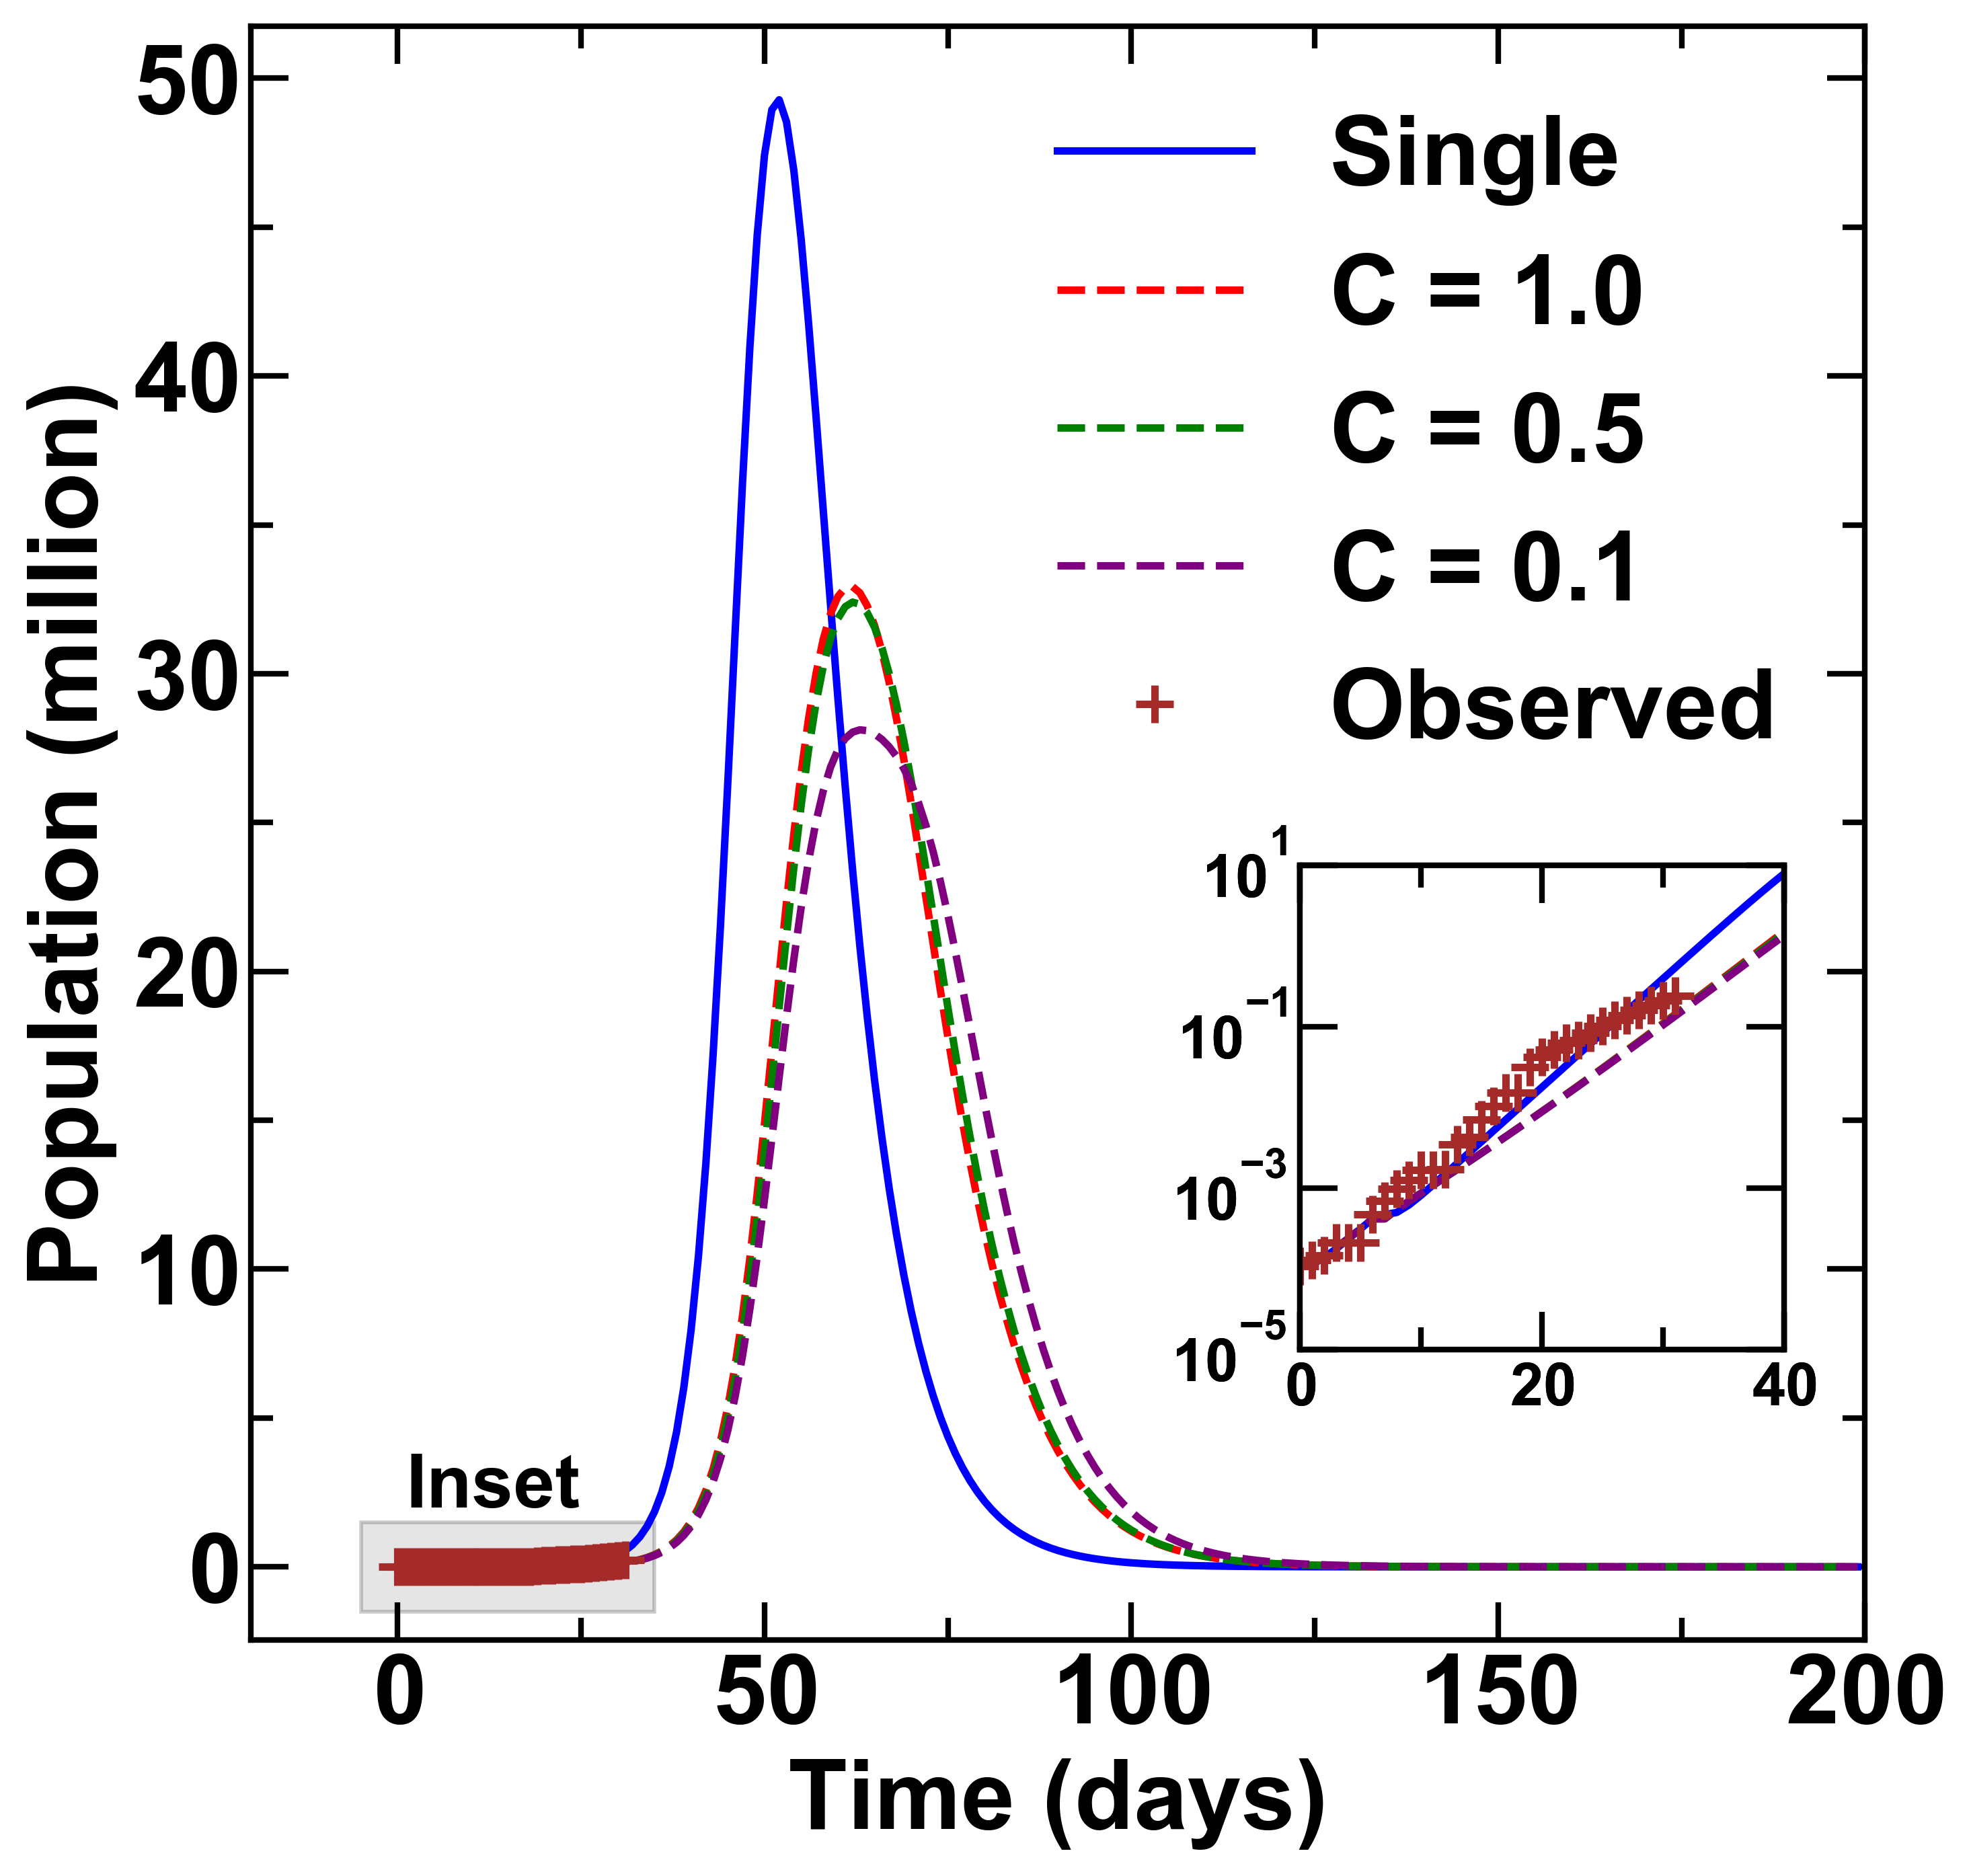

In [27]:
fig, [ax] = panel(1,1,dpi=400)
linestyles()

ydata0, DATA = get_data_US_plot('United States',0)
f1 = partial(func,POP=0.32e9,I0=ydata0[0])
R0 = 5.68
y = f1(range(7),R0/3)
f2 = partial(func,POP=0.32e9,I0=ydata0[6])
R0 = 6.13
y1 = f2(range(193),R0/3)

for i in y1:
    y=numpy.append (y, [i])
    
R2 = r2_score(ydata0,y[:len(ydata0)])

ax.plot(y/1e6,"-",label=r'Single')
ax.plot(yyyy_1/1e6,"--",label=r'C = 1.0')
#ax.plot(yyyy_0_75/1e6,"--",label=r'\textbf{C = 0.75}')
ax.plot(yyyy_0_50/1e6,"--",label=r'C = 0.5')
#ax.plot(yyyy_0_25/1e6,"--",label=r'\textbf{C = 0.25}')
ax.plot(yyyy_0_10/1e6,"--",label=r'C = 0.1')
#ax.plot(yyyy_0_00/1e6,"--",label=r'\textbf{C = 0.00}')
ax.plot(ydata0/1e6,"+",label=r'Observed',ms=10,mew=2)

rectangle(-5,35,-1.5,1.5,lw=1,ec='k')
text(13,2,r'Inset',ha='center',fontsize=20)

plt.ylabel(r'Population (million)')
plt.xlabel(r'Time (days)')
#plt.yscale('linear')
ax.legend(loc=1)
plt.xlim([-20,200])

linestyles()
ax2 = inset([0.65,0.18,0.3,0.3])

ax2.plot(y/1e6,"-",label=r'Single')
ax2.plot(yyyy_1/1e6,"--",label=r'C = 1.0')
#ax2.plot(yyyy_0_75/1e6,"--",label=r'\textbf{C = 0.75}')
ax2.plot(yyyy_0_50/1e6,"--",label=r'C = 0.5')
#ax2.plot(yyyy_0_25/1e6,"--",label=r'\textbf{C = 0.25}')
ax2.plot(yyyy_0_10/1e6,"--",label=r'C = 0.1')
#ax2.plot(yyyy_0_00/1e6,"--",label=r'\textbf{C = 0.00}')
ax2.plot(ydata0/1e6,"+",label=r'Observed',ms=10,mew=2)
plt.yscale('log')
plt.xlim([0,40])
plt.ylim([0.00001,10])

In [40]:
filename = "./USA_Images/"+'US_single_cluster'+".png"
fig.savefig(filename)

(5e-05, 0.5)

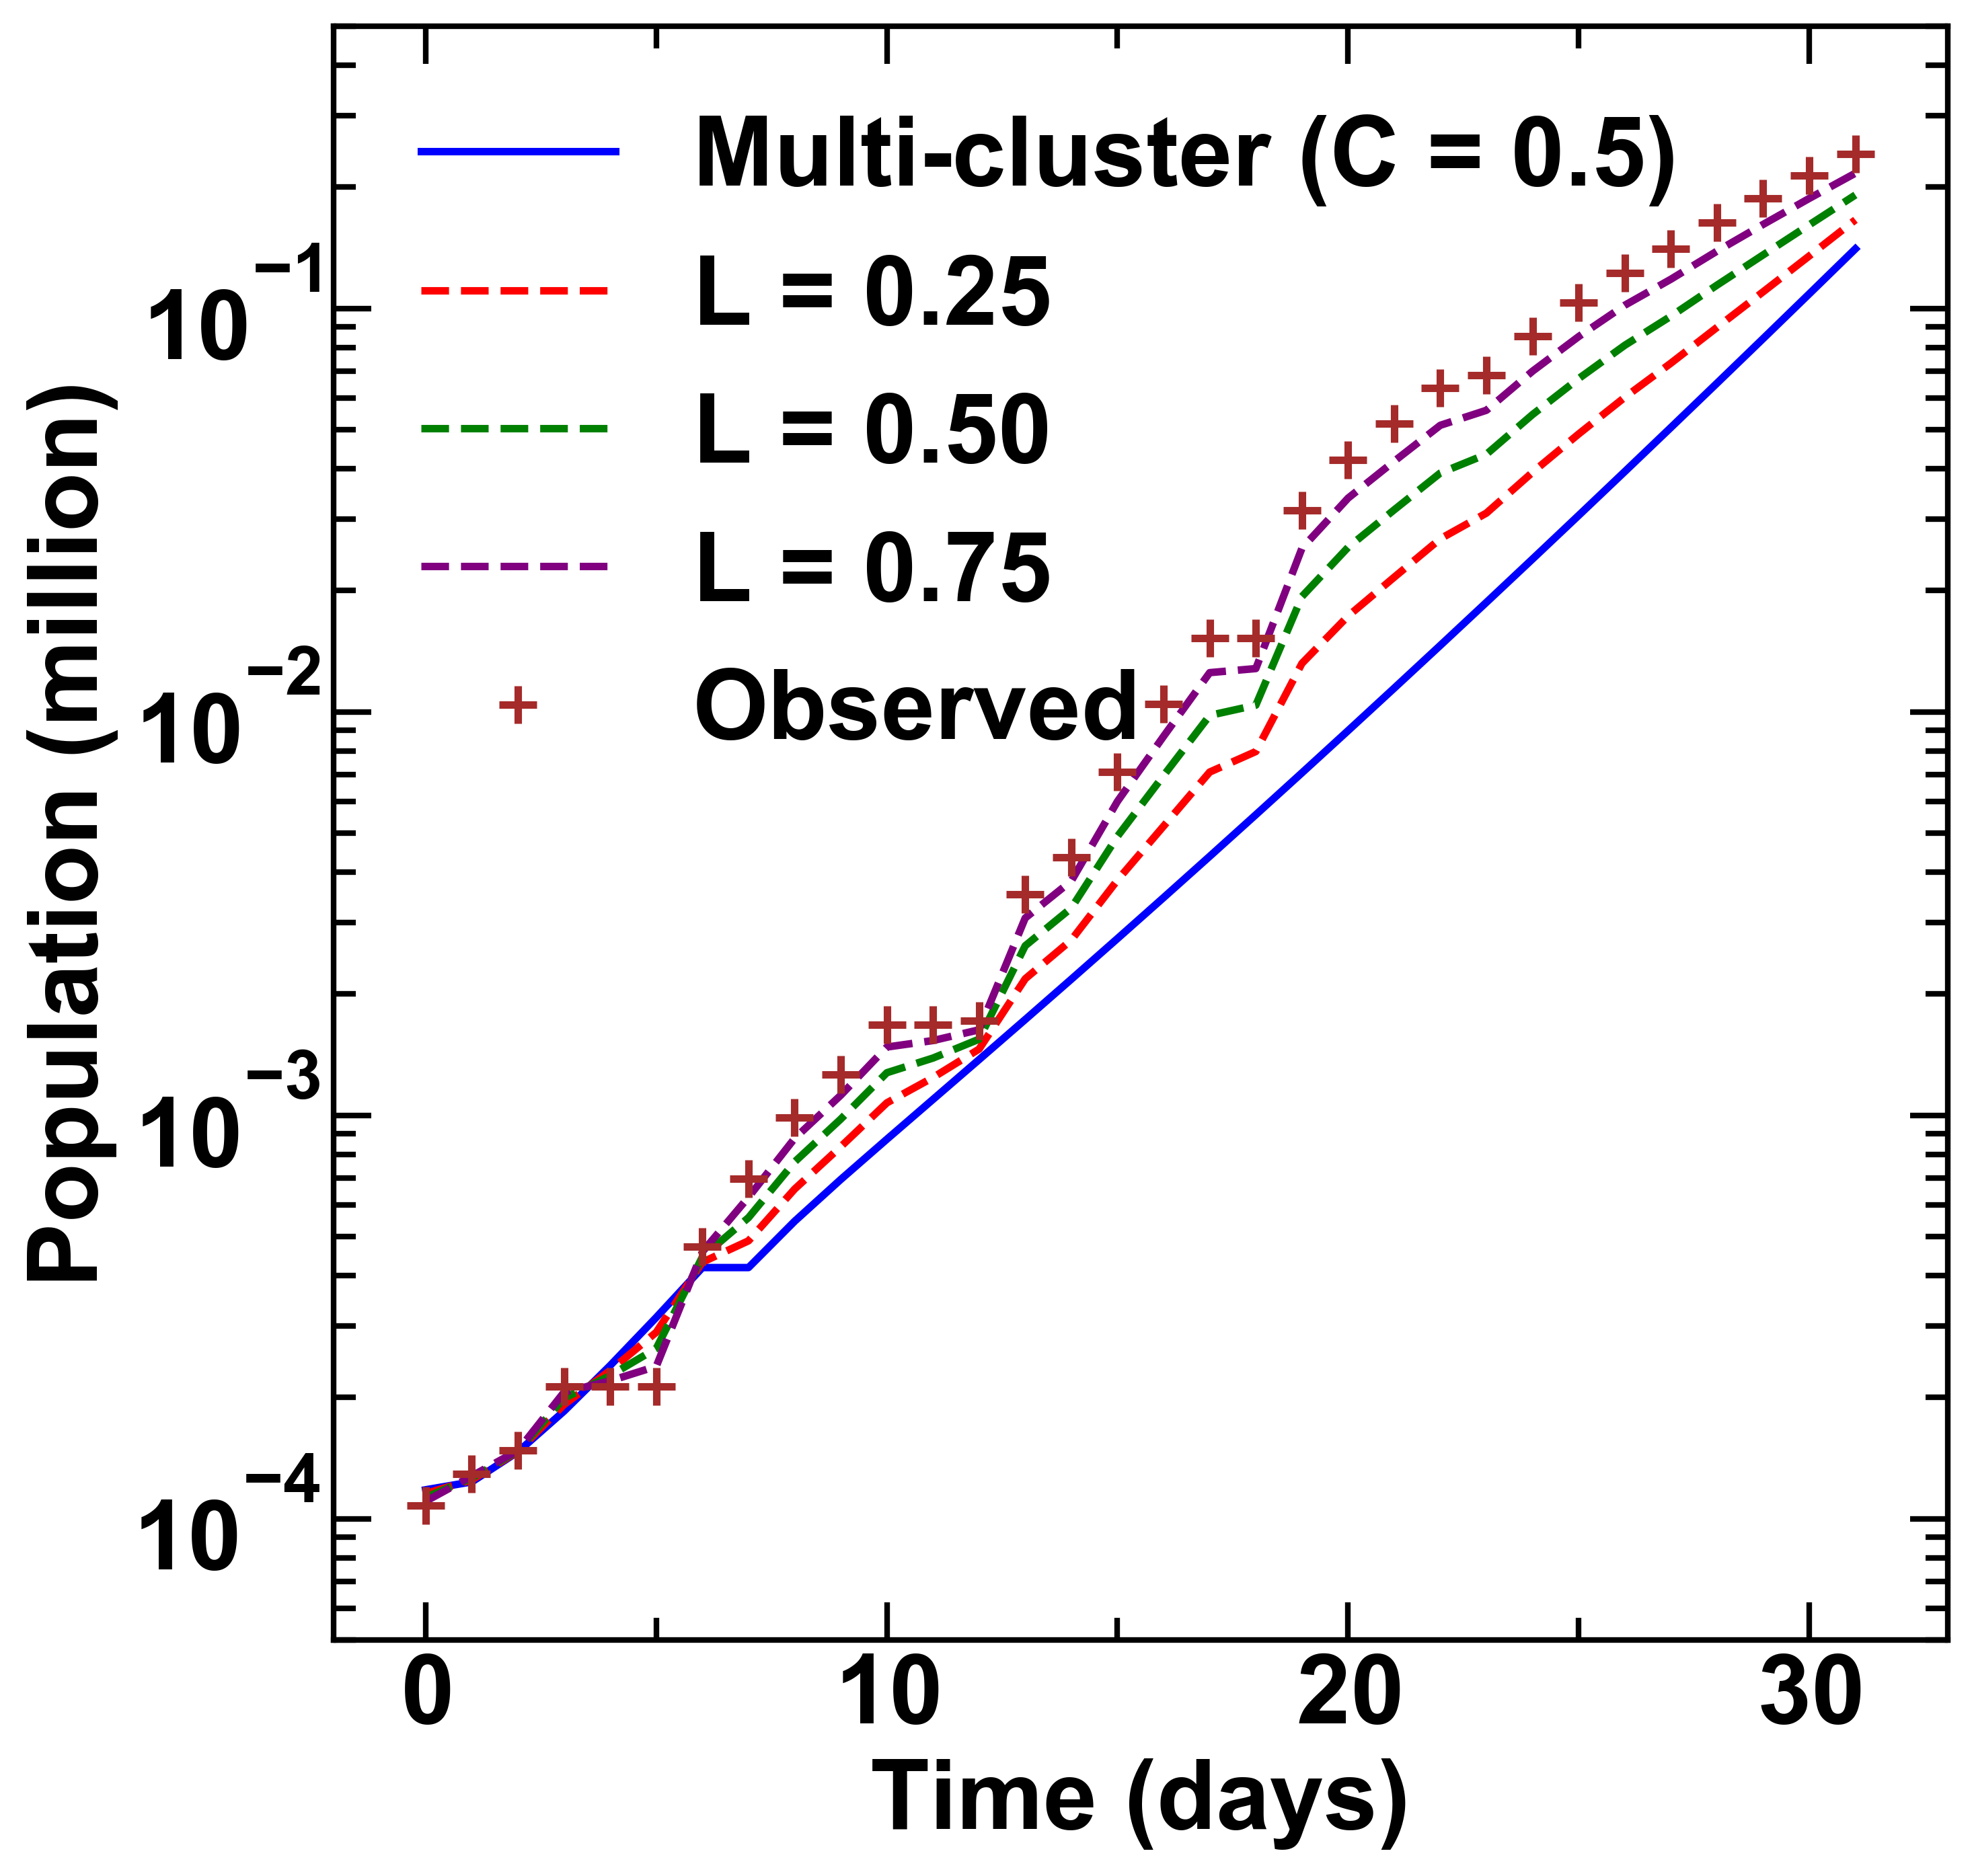

In [28]:
fig, [ax] = panel(1,1,dpi=400)
linestyles()

ydata0, DATA = get_data_US_plot('United States',0)
y2 = yyyy_0_50[:len(ydata0)]

ax.plot(y2/1e6,"-",label=r'Multi-cluster (C = 0.5)')

ax.plot((ydata0+3*y2)/4/1e6,"--",label=r'L = 0.25')
ax.plot((ydata0+y2)/2/1e6,"--",label=r'L = 0.50')
ax.plot((3*ydata0+y2)/4/1e6,"--",label=r'L = 0.75')

ax.plot(ydata0/1e6,"+",label=r'Observed',ms=10,mew=2)
plt.yscale('log')
plt.ylabel(r'Population (million)')
plt.xlabel(r'Time (days)')
ax.legend(loc=2)
plt.xlim([-2,33])
plt.ylim([5e-5,5e-1])

In [50]:
filename = "./USA_Images/"+'US-C-VALUE'+".png"
fig.savefig(filename)